In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
from luwiji.svm import illustration

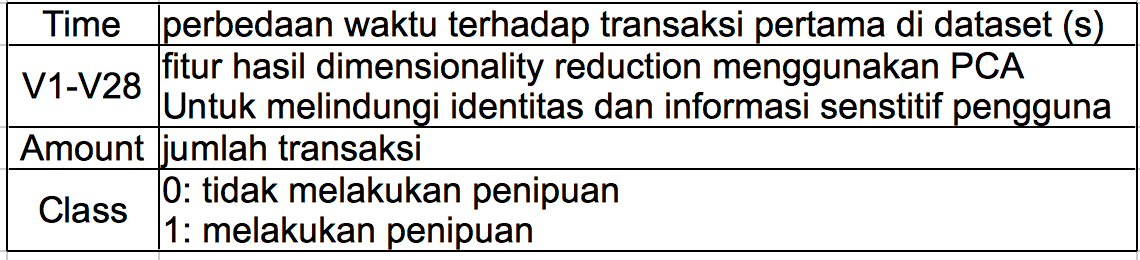

In [3]:
illustration.nomenklatur_cc_fraud

# Import Data

In [5]:
df = pd.read_csv('data/creditcard.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

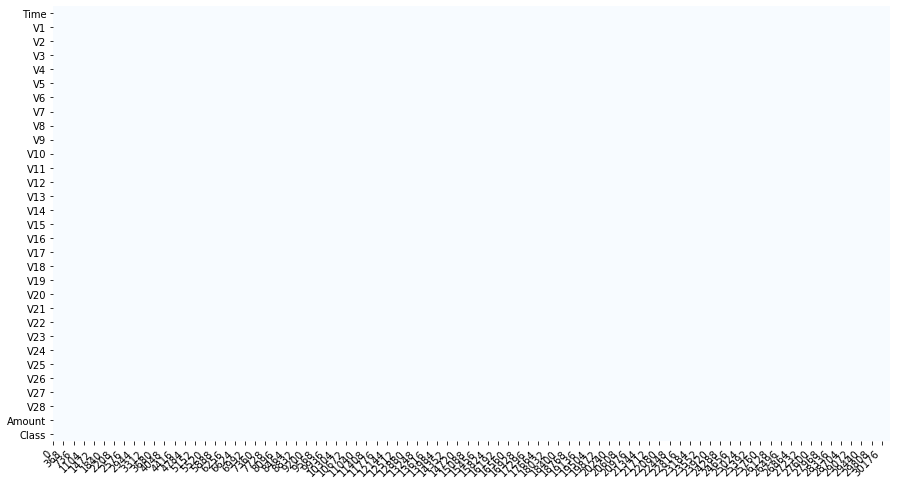

In [8]:
plot_missing_value(df)

# Dataset Splitting

In [9]:
#pakai stratified shuffle split karena problemnya clasification (e.g., Curant atau tidak curang)
X = df.drop(columns="Class")
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24393, 30), (6099, 30), (24393,), (6099,))

# Training

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [11]:
X_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'standard'), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   57.2s finished
D:\Miniconda3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.999385069487148 0.9986471528717256 0.9996720773897361


WOW! 99% test score. Ingat! setiap kali mendapatkan score setinggi itu, kita harus curiga dan cek kembali
- apakah terjadi data leakage
- apakah datasetnya imbalance
- apakah memang problemnya sesuatu yang sederhana

Pada kasus ini, dataset kita sebenarnya imbalance

In [14]:
df.Class.value_counts(normalize=True)

0    0.983865
1    0.016135
Name: Class, dtype: float64

# Akurasi tidak boleh dipakai pada Imbalance Dataset

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'standard'), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  1.2min finished
D:\Miniconda3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.980595084087969 0.9574909514939499 0.9896907216494846


In [18]:
from jcopml.plot import plot_confusion_matrix

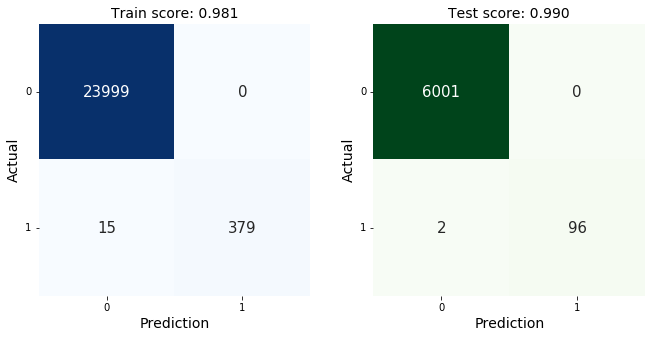

In [19]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Cara improv data imbalance -> class weight

In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'standard'), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500, class_weight='balanced'))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  1.3min finished
D:\Miniconda3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.01}
0.9752475247524752 0.9376681876681876 0.9700000000000001


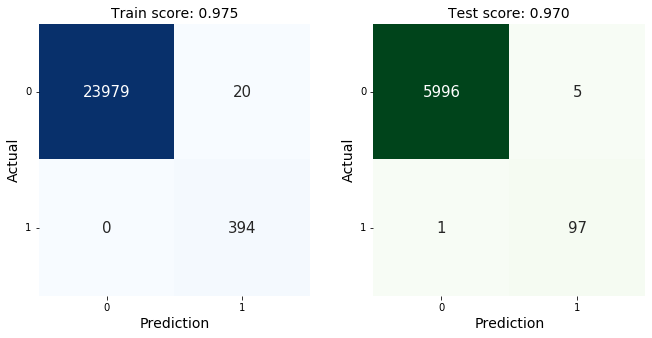

In [21]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)